In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from lsc import LangevinSparseCoding

In [ ]:
n_features = 4
n_latent = 3
sparsity_penalty = 1.
var = 1/sparsity_penalty
pi = 0.1
s0 = -var * np.log(pi)
temperature = 1
dt = 1e-2
mass = 1
NOISE_MEAN, NOISE_STD = 0 , 1

C = lambda s: s.abs().sum()
Cprime = lambda s: torch.sign(s)

lsc = LangevinSparseCoding(
    n_features=n_features,
    n_latent=n_latent,
    sparsity_penaly=sparsity_penalty,
    temperature=temperature,
    dt=dt,
    cost_function=C,
    cost_function_grad=Cprime,
    mass=mass,
    gauss_std=NOISE_STD,
)

A = torch.tensor([[1., 1., -1.],
                  [1., -0.1, -1.],
                  [-1., 1., 1.],
                  [1., -1., 1.]])

lsc.A = A
n_samples = int(1)
distribution = torch.distributions.Laplace(0.0, var)
s_star = distribution.sample(sample_shape=[n_samples,n_latent])
tmax = int(1e4)
epochs = 100
for i in range(epochs):
  x = (A@s_star.T).T + np.random.normal(NOISE_MEAN,NOISE_STD,size=)
  s_inference = torch.zeros_like(s_star)
  lsc.set_temperature(temperature = 0)
  for n in tqdm(range(tmax)):
      s_inference += lsc.first_order_langevin_update(x,s_inference) #Vanilla Gradient Descent
  s_map = s_inference

  lsc.set_temperature(temperature=1)
  S = []
  v = torch.zeros_like(s_star)
  for n in tqdm(range(tmax)):
      ds,dv = lsc.second_order_langevin_update(x,s_inference,v)
      s_inference += torch.clone(ds)
      v += torch.clone(dv)
      S.append(s_inference.data.numpy().copy())
  S = np.asarray(S)
  lsc.A = lsc.A + dt * lsc.dictionary_grad(x,s_map)
  lsc.normalize_dictionary()

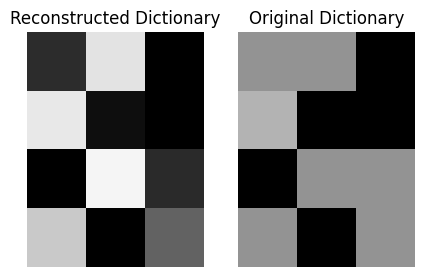

In [10]:
D_imgs = lsc.A
grid_img = torchvision.utils.make_grid(D_imgs, nrow=2).cpu()

fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax = ax.flatten()
ax[0].imshow(grid_img.permute(1, 2, 0))
ax[0].set_axis_off()
ax[0].set_title("Reconstructed Dictionary")
fig.set_size_inches(2, 2)
fig.canvas.draw()

D_imgs = A.div_(torch.norm(A, dim=1,keepdim=True))
grid_img = torchvision.utils.make_grid(D_imgs, nrow=2).cpu()

ax[1].imshow(grid_img.permute(1, 2, 0))
ax[1].set_axis_off()
ax[1].set_title("Original Dictionary")
fig.set_size_inches(5, 5)
fig.canvas.draw()